In [2]:
import bioframe as bf
import click
import pandas as pd
import time
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
GENE = "MYC"
CRISPR_FILENAME = "/oak/stanford/groups/engreitz/Projects/Benchmarking/CRISPR_data/EPCrisprBenchmark_ensemble_data_GRCh38.tsv.gz"
fragment_file = "/oak/stanford/groups/engreitz/Users/atan5133/scATAC_data/fragments_rosa_chr8.tsv"
TSS_FILE = "/oak/stanford/groups/engreitz/Users/atan5133/abc_run_comparisons/ABC-Enhancer-Gene-Prediction/reference/hg38/CollapsedGeneBounds.hg38.TS500bp.bed"

In [4]:
def does_overlap(start1, end1, start2, end2):
    if end1 <= start2 or end2 <= start1:
        return False
    else:
        return True

def find_region_idx(candidate_regions_df, coord):
    matching_elements = [idx for idx, row in candidate_regions_df.iterrows() if does_overlap(row["start"], row["end"], coord[0], coord[1])]
    if matching_elements:
        return matching_elements[0]
    return None

def get_crispr_record(region_idx, enh_df, enh_crispr_df):
    return enh_crispr_df[enh_crispr_df["start"] == enh_df.loc[region_idx, "start"]].iloc[0]

In [5]:
tss_df = pd.read_csv(TSS_FILE, sep="\t")
tss_df = tss_df.rename(columns={"#chr": "chrom"})
promoter_TSS = tss_df[tss_df["name"] == GENE].iloc[0][["start", "end"]].values

In [6]:
tss_df[tss_df["name"] == GENE].iloc[0][["chrom", "start", "end", "name"]]

chrom         chr8
start    127735818
end      127736318
name           MYC
Name: 8932, dtype: object

In [7]:
crispr_df = pd.read_csv(CRISPR_FILENAME, sep="\t").rename(columns={"chromStart": "start", "chromEnd": "end"})
crispr_df = crispr_df[(crispr_df["chrom"] == "chr8")].reset_index(drop=True)


# enh_tss_df = bf.overlap(enh_df, tss_df, how='inner', return_index=True)
# promoter_indexes = list(enh_tss_df["index"])

In [49]:
crispr_df.iloc[0]

dataset                                              Gasperini2019
chrom                                                         chr8
start                                                     11879271
end                                                       11880174
name                                 CTSB|chr8:11736780-11737683:.
EffectSize                                               -0.072544
chrTSS                                                        chr8
startTSS                                                11869447.0
endTSS                                                  11869448.0
measuredGeneSymbol                                            CTSB
Significant                                                   True
pValueAdjusted                                            0.016785
PowerAtEffectSize25                                            0.8
ValidConnection                                               True
CellType                                                      

In [8]:
crispr_enhancers = crispr_df.copy()[["chrom", "start", "end", "name"]]
promoter = tss_df[tss_df["name"] == GENE].iloc[0][["chrom", "start", "end", "name"]]
split_idx = sum(crispr_enhancers["start"] < promoter["start"])
crispr_enhancers = pd.concat([crispr_enhancers.loc[:split_idx - 1], pd.DataFrame([promoter.to_dict()]), crispr_enhancers.loc[split_idx:]])
crispr_enhancers = crispr_enhancers.drop_duplicates(subset=["chrom", "start", "end"]).reset_index(drop=True)

PROMOTER_IDX = find_region_idx(crispr_enhancers, promoter[["start", "end"]])

In [9]:
atac_df = pd.read_csv(
    fragment_file,
    sep="\t",
    names=["chrom", "start", "end", "barcode", "readSupport"],
)

In [10]:
overlap_df = bf.overlap(crispr_enhancers, atac_df, how="inner")

In [11]:
region_idx_map = {}
for idx, row in crispr_enhancers.iterrows():
    coordinates = (row["start"], row["end"])
    region_idx_map[coordinates] = idx

In [12]:
overlap_df

,chrom,start,end,name,chrom_,start_,end_,barcode_,readSupport_
0,chr8,11879271,11880174,CTSB|chr8:11736780-11737683:.,chr8,11879323,11879439,CCTATTTAGTGGCGGA-1,1
1,chr8,11879271,11880174,CTSB|chr8:11736780-11737683:.,chr8,11879327,11879509,AATAGAGGTTTAGCTC-1,1
2,chr8,11879271,11880174,CTSB|chr8:11736780-11737683:.,chr8,11879328,11879511,CACATACAGGCATTGT-1,3
3,chr8,11879271,11880174,CTSB|chr8:11736780-11737683:.,chr8,11879330,11879483,TCATGAGGTTGTGATG-1,1
4,chr8,11879271,11880174,CTSB|chr8:11736780-11737683:.,chr8,11879332,11879374,ACCTGGTCATTGACAT-1,1
...,...,...,...,...,...,...,...,...,...
287210,chr8,144691318,144692059,RPL8|chr8:145916703-145917444:.,chr8,144691307,144691505,AATTGTGTCAGCAAAG-1,2
287211,chr8,144691318,144692059,RPL8|chr8:145916703-145917444:.,chr8,144691307,144691559,CTCATTGTCCACCCTG-1,1
287212,chr8,144691318,144692059,RPL8|chr8:145916703-145917444:.,chr8,144691307,144691691,AGTGGACAGTTTGGTA-1,2
287213,chr8,144691318,144692059,RPL8|chr8:145916703-145917444:.,chr8,144691310,144691451,TGCTCTCAGTGTTGCG-1,1


In [13]:
barcode_map = defaultdict(dict)  # indexes associated with the barcode
for _, row in overlap_df.iterrows():
    coordinates = (row["start"], row["end"])
    idx = region_idx_map[coordinates]
    barcode_map[row["barcode_"]][idx] = row["readSupport_"]
    
TOTAL_CELLS = len(barcode_map)

matrix = pd.DataFrame(0,index=barcode_map.keys(), columns=range(len(region_idx_map)))
for barcode, indexes in barcode_map.items():
    matrix.loc[barcode] = indexes
matrix = matrix.fillna(0).astype(int)


In [14]:
# def qc_matrix(matrix, promoter_indexes):
#     """
#     Remove cells that don't have any active promoter
#     """
#     return matrix[matrix[promoter_indexes].sum(axis=1)>0]

# matrix = qc_matrix(matrix, promoter_indexes)
# TOTAL_CELLS = len(matrix)

In [15]:
# how many cells express promoter of that gene?
promoter_cells = matrix[matrix.loc[:, PROMOTER_IDX] >= 1]
non_promoter_cells = matrix[matrix.loc[:, PROMOTER_IDX] == 0]
len(promoter_cells) # 3090

2195

In [16]:
# enh_indexes
coords = crispr_df[(crispr_df["measuredGeneSymbol"] == GENE) & (crispr_df["Significant"])][["start", "end"]].values
enh_indexes = list({find_region_idx(crispr_enhancers, coord) for coord in coords})
enh_indexes

[449, 455, 456, 457, 519, 491, 527, 528, 529, 530]

In [17]:
matrix.loc[:,enh_indexes + [PROMOTER_IDX]][:5]

,449,455,456,457,519,491,527,528,529,530,434
CCTATTTAGTGGCGGA-1,0,0,0,0,0,0,0,1,0,0,2
AATAGAGGTTTAGCTC-1,0,0,0,0,0,0,0,0,0,0,0
CACATACAGGCATTGT-1,0,0,1,0,0,0,0,0,4,0,0
TCATGAGGTTGTGATG-1,0,1,0,0,1,0,0,0,0,0,0
ACCTGGTCATTGACAT-1,0,0,0,2,0,0,0,0,0,0,1


In [18]:
crispr_enhancers.iloc[sorted(enh_indexes)  + [PROMOTER_IDX]]

,chrom,start,end,name
449,chr8,127898896,127898963,MYC|chr8:128911142-128911209:*
455,chr8,127957679,127960199,MYC|chr8:128969925-128972445:*
456,chr8,127960391,127960502,MYC|chr8:128972637-128972748:*
457,chr8,127961319,127963819,MYC|chr8:128973565-128976065:*
491,chr8,128352539,128355079,MYC|chr8:129364785-129367325:*
519,chr8,129581780,129582461,MYC|chr8:130594026-130594707:*
527,chr8,129689360,129689694,MYC|chr8:130701606-130701940:*
528,chr8,129689879,129692379,MYC|chr8:130702125-130704625:*
529,chr8,129692458,129693217,MYC|chr8:130704704-130705463:*
530,chr8,129696899,129699399,MYC|chr8:130709145-130711645:*


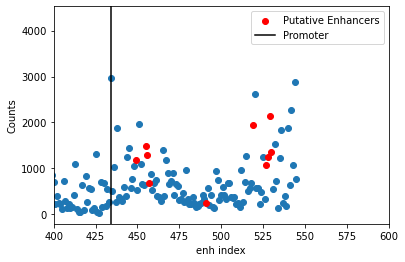

In [46]:
# Plot index counts

X, Y = [], []
put_X, put_Y = [], []
enh_counts = matrix.sum(axis=0)
for idx, count in enumerate(enh_counts):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(count)
    else:
        X.append(idx)
        Y.append(count)

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('Counts')
plt.legend()
plt.xlim(400, 600)
plt.show()

In [19]:
# create enh accessibility matrix
matrices = []
for enh_idx in range(len(crispr_enhancers)):  
    enh_on_prom_on = promoter_cells[enh_idx].sum()
    enh_off_prom_on = len(promoter_cells) - enh_on_prom_on
    enh_on_prom_off = non_promoter_cells[enh_idx].sum()
    enh_off_prom_off = len(non_promoter_cells) - enh_on_prom_off
    enh_matrix = pd.DataFrame(columns=["E_on", "E_off"])
    enh_matrix.loc["P_on"] = {"E_on": enh_on_prom_on, "E_off": enh_off_prom_on}
    enh_matrix.loc["P_off"] = {"E_on": enh_on_prom_off, "E_off": enh_off_prom_off}
#     enh_matrix.loc["E_sum"] = {"E_on": enh_matrix["E_on"].sum(), "E_off": enh_matrix["E_off"].sum()}
#     enh_matrix["P_sum"] = enh_matrix["E_on"] + enh_matrix["E_off"]
    matrices.append(enh_matrix)

In [20]:
from IPython.display import display
def print_matrices(matrices, only_putative=False):
    total_cells = len(matrix)
    for idx, enh_mat in enumerate(matrices):
        if only_putative and idx not in enh_indexes:
            continue
        display(enh_mat)
        ratio_enh_on = enh_mat.loc["P_on",'E_on'] / enh_mat.loc["P_off",'E_on']
        ratio_enh_off = enh_mat.loc["P_on",'E_off'] / enh_mat.loc["P_off",'E_off']
        ratio_prom_on = enh_mat.loc["P_on",'E_on'] / enh_mat.loc["P_on",'E_off']
        ratio_prom_off = enh_mat.loc["P_off",'E_on'] / enh_mat.loc["P_off",'E_off']
        ratio_5 = ratio_enh_on / ratio_enh_off
        ratio_6 = ratio_prom_on / ratio_prom_off
        print(f"enh: {idx}\n")
        print("Frequency of enhancer being on:")
        print("enh is on {:.2f}%".format(100*enh_mat['E_on'].sum() / total_cells))
        print("\t when prom on {:.2f}%".format(100*enh_mat.loc["P_on",'E_on'] / enh_mat.loc["P_on"].sum()))
        print("\t when prom off {:.2f}%".format(100*enh_mat.loc["P_off",'E_on'] / enh_mat.loc["P_off"].sum()))
        print()
        print("Frequency of promoter being on:")
        print("prom is on {:.2f}%".format(100*enh_mat.loc["P_on"].sum() / total_cells))
        print("\t when enh on {:.2f}%".format(100*enh_mat.loc["P_on",'E_on'] / enh_mat["E_on"].sum()))
        print("\t when enh off {:.2f}%".format(100*enh_mat.loc["P_on",'E_off'].sum() / enh_mat["E_off"].sum()))
        print()
        print("Ratios (want high): 1={:.2f}, 3={:.2f}, 5={:.2f}, 6={:.2f}".format(
            ratio_enh_on, ratio_prom_on, ratio_5, ratio_6))
        print("Ratios (want low): 2={:.2f}, 4={:.2f}".format(
            ratio_enh_off, ratio_prom_off))

In [21]:
# print_matrices(matrices, only_putative=True)

In [22]:
# print_matrices(matrices, only_putative=False)

In [23]:
# Plot bayesian probabilities 
def compute_P_p_e(matrix):
    num_e_on = matrix["E_on"].sum()
    return matrix.loc["P_on", "E_on"] / num_e_on

def compute_P_e_p(matrix):
    num_p_on = len(promoter_cells)
    return matrix.loc["P_on", "E_on"] / num_p_on

def compute_P_e(matrix):
    return matrix["E_on"].sum() / TOTAL_CELLS


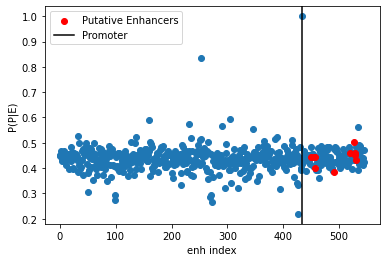

In [24]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_p_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_p_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(P|E)')
plt.legend()
plt.show()

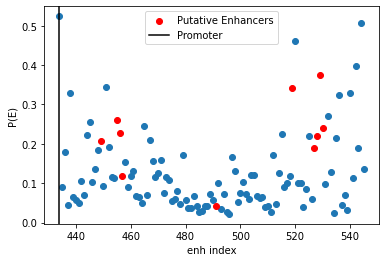

In [25]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx < PROMOTER_IDX:
        continue
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E)')
plt.legend()
plt.show()

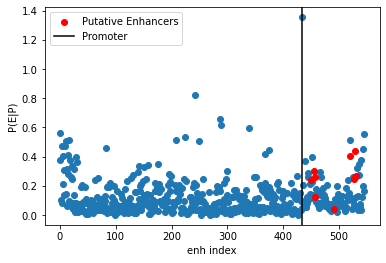

In [26]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e_p(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e_p(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E|P)')
plt.legend()
plt.show()

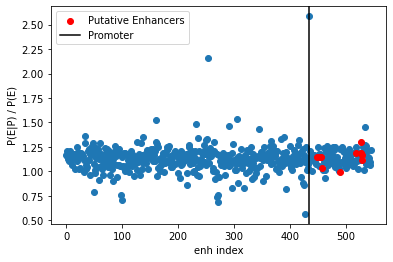

In [27]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e_p(enh_mat) / compute_P_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e_p(enh_mat) / compute_P_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E|P) / P(E)')
plt.legend()
plt.show()

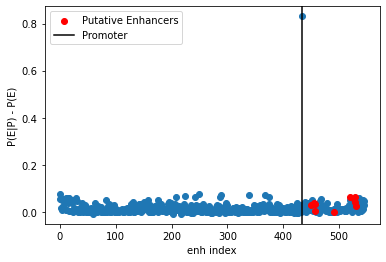

In [28]:
X, Y = [], []
put_X, put_Y = [], []
for idx, enh_mat in enumerate(matrices):
    if idx in enh_indexes:
        put_X.append(idx)
        put_Y.append(compute_P_e_p(enh_mat) - compute_P_e(enh_mat))
    else:
        X.append(idx)
        Y.append(compute_P_e_p(enh_mat) - compute_P_e(enh_mat))

plt.scatter(X,Y)
plt.scatter(put_X,put_Y, color='red', label="Putative Enhancers")
plt.axvline(x=PROMOTER_IDX, color="black", linestyle="-", label=f"Promoter")
plt.xlabel('enh index')
plt.ylabel('P(E|P) - P(E)')
plt.legend()
plt.show()

In [29]:
# Find strong enhancers by looking at strong ones
scores = []
for enh_idx in range(len(enh_df)):
    score = promoter_cells.loc[:,enh_idx].sum()
    scores.append((score, enh_idx))

strong_scores = list(reversed(sorted(scores)))
print(f"num promoter cells: {len(promoter_cells)}")
strong_scores
    

NameError: name 'enh_df' is not defined

In [ ]:
# Find strong enh by looking at weak ones. Low score => strong
scores = []
for enh_idx in range(len(enh_df)):
    score = non_promoter_cells.loc[:,enh_idx].sum()
    scores.append((score, enh_idx))

weak_scores = list((sorted(scores)))
print(f"num non promoter cells: {len(non_promoter_cells)}")
weak_scores

In [ ]:
def find_idx_of_enh(score_list, enh_idx):
    for i, (score, idx) in enumerate(score_list):
        if idx == enh_idx:
            return i

In [ ]:
for i in range(10):
    enh_idx = strong_scores[i][1]
    print(enh_idx, find_idx_of_enh(strong_scores, enh_idx), find_idx_of_enh(weak_scores, enh_idx))

In [ ]:
# How often is at least 1 putative enh active when promoter is on?
enh_counts = promoter_cells.loc[:, enh_indexes].sum(axis=1)
num_cells = promoter_cells[enh_counts > 0]
print(len(num_cells)/len(promoter_cells))

In [ ]:
# What is the distribution of how many putative enhancers are on for promoter cells?
import matplotlib.pyplot as plt
plt.hist(enh_counts, color='b', edgecolor='black', bins=6, density=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of a Distribution')

In [ ]:
# What is the distribution for how many cells are promoters based on # of putative enh turned on?
matrix["num_put_enh"] = matrix.loc[:,enh_indexes].sum(axis=1)
promoter_cells = matrix[matrix.loc[:, promoter_idx] == 1]
non_promoter_cells = matrix[matrix.loc[:, promoter_idx] == 0]

In [ ]:
data = []
for num_indexes in range(len(enh_indexes)):
    prom_count = (promoter_cells.loc[:, "num_put_enh"] == num_indexes).sum()
    non_prom_count = (non_promoter_cells.loc[:, "num_put_enh"] == num_indexes).sum()
    data.append((num_indexes, prom_count / (prom_count + non_prom_count)))
x, y = zip(*data)
plt.bar(x,y)
plt.xlabel('Num Putative Enhancers')
plt.ylabel('Perecentage that are promoters')
print(data)

In [ ]:
# When enh 155, why doesn't it cause promoters to be active?
# Are there additional enhancers that it works well with? Activation threshold?
# Let's see what putative enh it tends to pair with when promoter is active
promoter_cells[promoter_cells[155]==1].loc[:,enh_indexes+["num_put_enh"]][:30]

In [ ]:
# When enh 155, why doesn't it cause promoters to be active?
# Are there additional enhancers that it works well with? Activation threshold?
# Let's see what putative enh it tends to pair with when promoter is active
non_promoter_cells[non_promoter_cells[155]==1].loc[:,enh_indexes+["num_put_enh"]][:30]

In [ ]:
# When enh 155 is on, how often is promoter on? (both on / all enh 155 on)
# When enh 155 is off, how often is promoter off? (both off / all enh 155 off)
# How do those values differ from the average of promoter on and off rates?
enh_idx = 155
promoter_on_pct = len(promoter_cells) / len(matrix)
promoter_off_pct = len(non_promoter_cells) / len(matrix)
print("Promoter on/off pct", promoter_on_pct, promoter_off_pct)

enh_155_on = matrix[enh_idx].sum()
on_on_count = (promoter_cells[enh_idx] == 1).sum() / enh_155_on
enh_155_off = len(matrix) - enh_155_on
off_off_count = (non_promoter_cells[enh_idx]==0).sum() / enh_155_off
print("Enh/Prom on/off pct", on_on_count, off_off_count)

In [ ]:
prom_enh_counts = promoter_cells[enh_df.index].sum(axis=1)
print(prom_enh_counts.mean(), prom_enh_counts.std(), prom_enh_counts.median())

In [ ]:
prom_enh_counts = non_promoter_cells[enh_df.index].sum(axis=1)
print(prom_enh_counts.mean(), prom_enh_counts.std(), prom_enh_counts.median())

In [ ]:
genes = tss_df[tss_df["chrom"] == "chr8"]["name"].unique()

In [ ]:
crispr_df[(crispr_df["measuredGeneSymbol"].isin(genes)) & crispr_df["Significant"]].groupby("measuredGeneSymbol").size()

In [ ]:
len(matrix)

In [ ]:
crispr_df = crispr_df.rename(columns={"chromStart": "start", "chromEnd": "end"})

In [ ]:
crispr_enh_df = crispr_df[["chrom", "start", "end"]].drop_duplicates().reset_index(drop=True)

In [ ]:
overlap_df = bf.overlap(crispr_enh_df, atac_df, how="inner", return_index=True)

In [ ]:
for barcode, df in overlap_df.groupby("barcode_"):
    print(barcode)
    print(df["index"].unique())
    break

In [ ]:
start = time.time()
m = pd.DataFrame(0, index=overlap_df["barcode_"].unique(), columns=range(overlap_df["index"].max()+1))
for barcode, df in overlap_df.groupby("barcode_"):
    enh_indices = df["index"]
    matrix.loc[barcode] = {idx: 1 for idx in enh_indices}

m = matrix.fillna(0).astype(int)
print(time.time() - start)

In [ ]:
matrix